# Предсказание ментальных проблем на основе данных о студентах

In [248]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, Birch
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, r2_score, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [249]:
data = pd.read_csv('../datasets/mentalhealth_dataset.csv')
data.head()

,Timestamp,Gender,Age,Course,YearOfStudy,CGPA,Depression,Anxiety,PanicAttack,SpecialistTreatment,SymptomFrequency_Last7Days,HasMentalHealthSupport,SleepQuality,StudyStressLevel,StudyHoursPerWeek,AcademicEngagement
0,13/7/2020,Female,24,Biotechnology,Year 3,2.38,1,0,0,0,5,0,4,5,8,2
1,13/7/2020,Female,18,Biotechnology,Year 3,4.00,0,1,0,0,0,0,4,4,13,5
2,13/7/2020,Female,25,Biotechnology,Year 3,3.68,0,0,1,0,3,0,1,2,13,1
3,13/7/2020,Female,18,Engineering,year 4,4.00,0,0,0,0,3,0,5,1,19,2
4,13/7/2020,Female,20,Engineering,year 4,2.00,1,1,0,0,0,0,2,4,3,2


## 0. Предварительная обработка данных

In [250]:
data.isna().sum() # выбросов нет, победа!

Timestamp                     0
Gender                        0
Age                           0
Course                        0
YearOfStudy                   0
CGPA                          0
Depression                    0
Anxiety                       0
PanicAttack                   0
SpecialistTreatment           0
SymptomFrequency_Last7Days    0
HasMentalHealthSupport        0
SleepQuality                  0
StudyStressLevel              0
StudyHoursPerWeek             0
AcademicEngagement            0
dtype: int64

| Столбец                         | Описание                                                                        |
|---------------------------------|---------------------------------------------------------------------------------|
| `Timestamp`                     | Временная метка заполнения данных, используется для временной привязки.         |
| `Gender`                        | Пол участника, например, мужской, женский, или другой вариант.                  |
| `Age`                           | Возраст участника, выраженный в годах.                                          |
| `Course`                        | Курс обучения участника (например, специальность или направление обучения).     |
| `YearOfStudy`                   | Год обучения (например, 1-й, 2-й, 3-й курс и т.д.).                             |
| `CGPA`                          | Кумулятивный средний балл (средний балл академической успеваемости).            |
| `Depression`                    | Наличие депрессии                                                               |
| `Anxiety`                       | Наличие тревожного расстройства                                                 |
| `PanicAttack`                   | Наличие панических атак, например                                               |
| `SpecialistTreatment`           | Получает ли участник специализированное лечение у врача или психолога.          |
| `SymptomFrequency_Last7Days`    | Частота проявления симптомов (например, депрессии, тревоги) за последние 7 дней.|
| `HasMentalHealthSupport`        | Есть ли у участника доступ к поддержке в области психического здоровья.         |
| `SleepQuality`                  | Качество сна участника                                                          |
| `StudyStressLevel`              | Уровень стресса, связанный с учебой                                             |
| `StudyHoursPerWeek`             | Количество часов, посвященных учебе в неделю.                                   |
| `AcademicEngagement`            | Уровень вовлеченности в учебный процесс                                         |


Уберем столбец Timestamp, он только будет путать модель, тк время абсолютно не важно в нашей задаче

In [251]:
if 'Timestamp' in data.columns: # необязательное условие (чтобы много раз запускать ячейку)
    data = data.drop('Timestamp', axis=1)

data = pd.get_dummies(data, columns=['Gender', 'Course'], drop_first=True)
data.head()

,Age,YearOfStudy,CGPA,Depression,Anxiety,PanicAttack,SpecialistTreatment,SymptomFrequency_Last7Days,HasMentalHealthSupport,SleepQuality,...,Course_Pendidikan Islam,Course_Pendidikan Islam,Course_Pendidikan islam,Course_Psychology,Course_Radiography,Course_TAASL,Course_Usuluddin,Course_engin,Course_koe,Course_psychology
0,24,Year 3,2.38,1,0,0,0,5,0,4,...,False,False,False,False,False,False,False,False,False,False
1,18,Year 3,4.00,0,1,0,0,0,0,4,...,False,False,False,False,False,False,False,False,False,False
2,25,Year 3,3.68,0,0,1,0,3,0,1,...,False,False,False,False,False,False,False,False,False,False
3,18,year 4,4.00,0,0,0,0,3,0,5,...,False,False,False,False,False,False,False,False,False,False
4,20,year 4,2.00,1,1,0,0,0,0,2,...,False,False,False,False,False,False,False,False,False,False


В столбце YearOfStudy данные представлены в виде year ... Надо приводить все это к числовому признаку

In [252]:
if data['YearOfStudy'].apply(lambda x: isinstance(x, str)).sum():  # необязательное условие (чтобы много раз запускать ячейку)
    data['YearOfStudy'] = data['YearOfStudy'].apply(lambda x: int(x.split()[1]))
data['YearOfStudy'].unique()

array([3, 4, 2, 1], dtype=int64)

Видим много столбцов с категориальными признаками, запишем их названия в отдельный список (тут проще написать числовые признаки)

In [253]:
data.columns

Index(['Age', 'YearOfStudy', 'CGPA', 'Depression', 'Anxiety', 'PanicAttack',
       'SpecialistTreatment', 'SymptomFrequency_Last7Days',
       'HasMentalHealthSupport', 'SleepQuality', 'StudyStressLevel',
       'StudyHoursPerWeek', 'AcademicEngagement', 'Gender_Male',
       'Course_Accounting ', 'Course_BCS', 'Course_BENL', 'Course_BIT',
       'Course_Banking Studies', 'Course_Benl', 'Course_Biomedical science',
       'Course_Biotechnology', 'Course_Business Administration', 'Course_CTS',
       'Course_Communication ', 'Course_DIPLOMA TESL',
       'Course_Diploma Nursing', 'Course_ENM', 'Course_Econs', 'Course_Engine',
       'Course_Engineering', 'Course_Fiqh', 'Course_Fiqh fatwa ',
       'Course_Human Resources', 'Course_Human Sciences ', 'Course_IT',
       'Course_Irkhs', 'Course_Islamic Education', 'Course_Islamic education',
       'Course_KENMS', 'Course_KIRKHS', 'Course_KOE', 'Course_Kirkhs',
       'Course_Koe', 'Course_Kop', 'Course_Law', 'Course_Laws', 'Course_MHSC',

In [254]:
num_cols = [
    'CGPA', 'Age', 'YearOfStudy', 'StudyHoursPerWeek', 
    'StudyStressLevel', 'SleepQuality', 'AcademicEngagement', 
    'SymptomFrequency_Last7Days'
]
cat_cols = list(set(data.columns) - set(num_cols))

## Немного визуализации

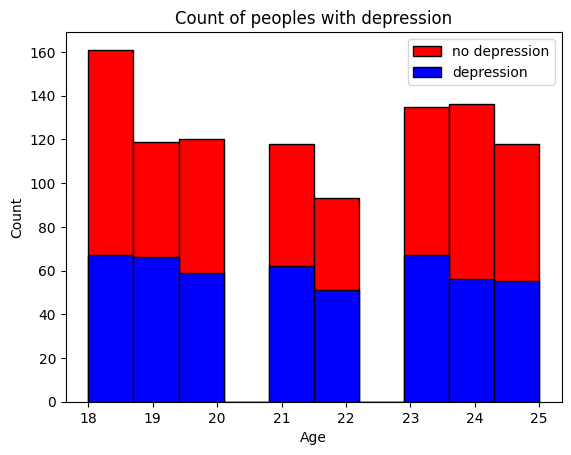

In [255]:
plt.hist(data['Age'], bins=10, color='red', edgecolor='black', label='no depression')
plt.hist(data[data['Depression'] == 1]['Age'], bins=10, color='blue', edgecolor='black', label='depression')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Count of peoples with depression')
plt.legend()
plt.show()


## 1. Обучите и примените по крайней мере две модели кластеризации
Делаем нормализацию, чтобы модель правильно взвешивала каждый из признаков

In [256]:
def draw_clusters(model_type, dt):
    dt = dt.copy()
    fig, axes = plt.subplots(nrows=2, ncols=3)
    
    for count_of_clusters, ax in enumerate(axes.flat):
        model = model_type(n_clusters=(count_of_clusters + 2))
        dt['Cluster'] = model.fit_predict(final_data)
        
        ax.scatter(dt['Age'], dt['CGPA'], c=dt['Cluster'], cmap='viridis', s=40, alpha=0.5)
        ax.set_xlabel('Age')
        ax.set_ylabel('CGPA')
        ax.set_title(f'clusters: {count_of_clusters + 2}')
    
    fig.suptitle('Разделяем данные на n кластеров')
    plt.tight_layout()
    plt.show()

In [257]:
copy_data = data.copy()
scaler = StandardScaler()
scaled_num_data = scaler.fit_transform(copy_data[num_cols])
final_data = pd.concat([pd.DataFrame(scaled_num_data, columns=num_cols), copy_data[cat_cols]], axis=1)

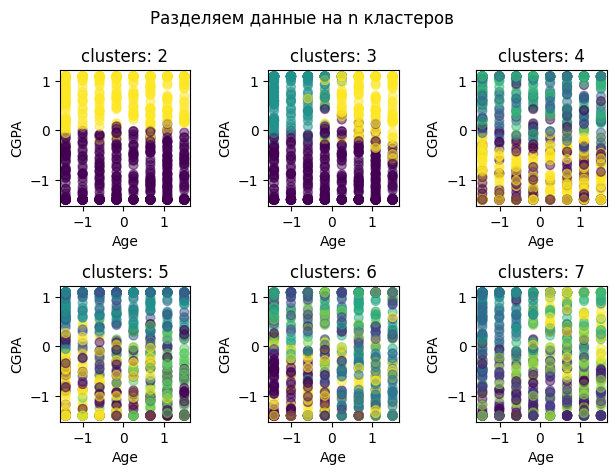

In [258]:
draw_clusters(KMeans, final_data)

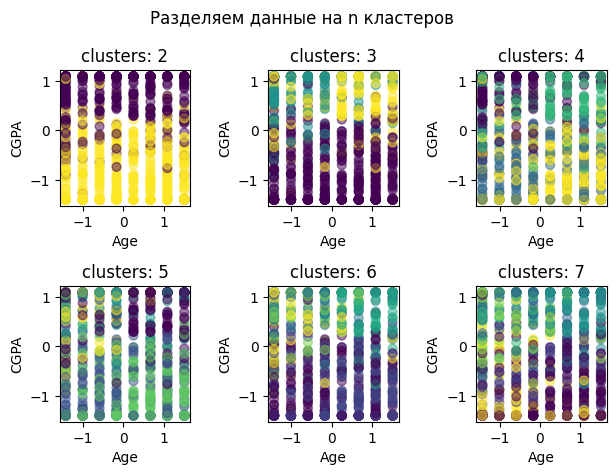

In [259]:
draw_clusters(Birch, final_data)

## 2. Обучите и примените по крайней мере две модели классификации
Попробуем предсказать есть ли у человека депрессия или нет 

In [260]:
X = data.drop('Depression', axis=1)
y = data['Depression']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52) # Делим данные

Теперь сделаем нормализацию на разделенных данных

Формула для StandardScaler:

$$z = \frac{x - \mu}{\sigma}$$

z — стандартизированное значение;
x — исходное значение;
$\mu$ — среднее значение признака (mean);
$\sigma$ — стандартное отклонение признака.
StandardScaler вычитает среднее значение из каждого пункта данных, а затем делит результат на стандартное отклонение. В результате получается набор данных со средним значением 0 и стандартным отклонением 1.


$$\text{Accuracy} = \frac{\text{Количество верных предсказаний}}{\text{Общее количество предсказаний}} = \frac{TP + TN}{TP + TN + FP + FN}$$  


$$\text{F1-score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

### Логистическая регрессия

In [261]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # fit`им только train данные, иначе модель запомнит тестовые 
X_test_scaled = scaler.transform(X_test)

In [262]:
lg_model = LogisticRegression()
lg_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [263]:
y_pred = lg_model.predict(X_test_scaled)
print(f'PREDICTIONS ON TRAIN\n'
      f'accuracy: {accuracy_score(y_train, lg_model.predict(X_train_scaled))}\n'
      f'f1_score: {f1_score(y_train, lg_model.predict(X_train_scaled))}\n\n'
      f'PREDICTIONS ON TEST\n'
      f'accuracy: {accuracy_score(y_test, y_pred)}\n'
      f'f1_score: {f1_score(y_test, y_pred)}\n')

PREDICTIONS ON TRAIN
accuracy: 0.65
f1_score: 0.6359583952451708

PREDICTIONS ON TEST
accuracy: 0.61
f1_score: 0.5951557093425606



Проверим, что будет без нормализации

In [264]:
lg_model = LogisticRegression()
lg_model.fit(X_train, y_train)
y_pred = lg_model.predict(X_test)

print(f'PREDICTIONS ON TRAIN\n'
      f'accuracy: {accuracy_score(y_train, lg_model.predict(X_train))}\n'
      f'f1_score: {f1_score(y_train, lg_model.predict(X_train))}\n\n'
      f'PREDICTIONS ON TEST\n'
      f'accuracy: {accuracy_score(y_test, y_pred)}\n'
      f'f1_score: {f1_score(y_test, y_pred)}\n')

PREDICTIONS ON TRAIN
accuracy: 0.6542857142857142
f1_score: 0.6430678466076696

PREDICTIONS ON TEST
accuracy: 0.6166666666666667
f1_score: 0.6020761245674741



Стало хуже, но это дело случая, на самом деле на конкретно этих данных модель не будет склоняться к какому-либо признаку больше, нежели к другому (все числовые колонки обладают относительно маленьким средним)

### KNN - классификатор

In [265]:
knn_model = KNeighborsClassifier(n_neighbors=18)
knn_model.fit(X_train_scaled, y_train)
y_pred = knn_model.predict(X_test_scaled)

print(f'PREDICTIONS ON TRAIN\n'
      f'accuracy: {accuracy_score(y_train, knn_model.predict(X_train_scaled))}\n'
      f'f1_score: {f1_score(y_train, knn_model.predict(X_train_scaled))}\n\n'
      f'PREDICTIONS ON TEST\n'
      f'accuracy: {accuracy_score(y_test, y_pred)}\n'
      f'f1_score: {f1_score(y_test, y_pred)}\n')

PREDICTIONS ON TRAIN
accuracy: 0.5885714285714285
f1_score: 0.5688622754491018

PREDICTIONS ON TEST
accuracy: 0.5366666666666666
f1_score: 0.4981949458483754



## 3. Обучите и примените по крайней мере одну модель оценки непрерывного показателя

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^n \left( y_i - \hat{y}_i \right)^2$$

$$R^2 = 1 - \frac{\sum_{i=1}^n \left( y_i - \hat{y}_i \right)^2}{\sum_{i=1}^n \left( y_i - \bar{y} \right)^2}$$

In [266]:
X = data.drop('CGPA', axis=1)
y = data['CGPA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52) # Делим данные

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dtree = DecisionTreeRegressor()
dtree.fit(X_train_scaled, y_train)
y_pred = dtree.predict(X_test_scaled)

print(f'PREDICTIONS ON TRAIN\n'
      f'MSE: {mean_squared_error(y_train, dtree.predict(X_train_scaled))}\n'
      f'R2: {r2_score(y_train, dtree.predict(X_train_scaled))}\n\n'
      f'PREDICTIONS ON TEST\n'
      f'MSE: {mean_squared_error(y_test, y_pred)}\n'
      f'R2: {r2_score(y_test, y_pred)}\n')

PREDICTIONS ON TRAIN
MSE: 0.0
R2: 1.0

PREDICTIONS ON TEST
MSE: 0.076751
R2: 0.8834796389694144



r2_score стремится к 0.9, это очень много, обычно r2_score меньше 0.8